In [1]:
# cleaning (empty, outlier) using mean/mode; xgboost BUT FOR TARGET I REMOVED NaN VERSION 3
# Tx is TARGET
# no ffill
#WORKSPACE NOMBER TWO TO PREVENT OVERFITTING
#REMOVE SSB IDX
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
# from imblearn.over_sampling import SMOTENC
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

from typing import List, Dict
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score
import numpy as np 
import matplotlib.pyplot as plt

from collections import OrderedDict
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
from sklearn.metrics import confusion_matrix

# File path
input_file = r"~/Downloads/CHI-JA-WLOOP-VZW-HTTP-MERGED.csv"

# Read the CSV file without specifying columns to inspect the column names
df = pd.read_csv(input_file)


# List of columns you want to keep in the output CSV
columns_to_keep = [
    "5G KPI PCell RF Serving PCI", 
    "5G KPI PCell RF Frequency [MHz]", 
    "5G KPI PCell RF Subcarrier Spacing",
#     "5G KPI PCell RF Duplex Mode",
    "5G KPI PCell RF Tx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 1",
#     "5G KPI PCell RF Serving SSB Idx",
    "5G KPI PCell RF Serving SS-RSRP [dBm]", 
    "5G KPI PCell RF Serving SS-RSRQ [dB]",
    "5G KPI PCell RF Serving SS-SINR [dB]",
    "5G KPI PCell RF Pathloss [dB]",
    "5G KPI PCell RF RI",
    "5G KPI PCell RF RI1 Rate [%]",
    "5G KPI PCell RF RI2 Rate [%]",
    "5G KPI PCell RF CQI",
    "5G KPI PCell RF PMI i(1;1)",
    "5G KPI PCell RF PMI i(1;2)",
    "5G KPI PCell RF PMI i(1;3)",
    "5G KPI PCell RF PMI i(2)",
    "5G KPI PCell RF LI",
    "5G KPI PCell RF TA",
    "5G KPI PCell RF PRACH Power [dBm]",
    "5G KPI PCell RF PUSCH Power [dBm]", 
    "5G KPI PCell RF PUCCH Power [dBm]",
    "5G KPI PCell RF SRS Power [dBm]",
    "5G KPI PCell RF ENDC Tx Power [dBm]",
    "5G KPI PCell RF Neighbor Top1 PCI",
    "5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top2 PCI",
    "5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top3 PCI",
    "5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]",
    "5G KPI PCell Layer1 DL BLER [%]",
    "5G KPI PCell Layer1 UL BLER [%]",
    "5G KPI PCell Layer1 DL RB Num (Avg)",
    "5G KPI PCell Layer1 UL RB Num (Avg)",
    "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
    "5G KPI PCell Layer1 PUSCH Throughput [Mbps]"
    

]

# Read the input CSV file
df = pd.read_csv(input_file, low_memory=False)

# Check the initial shape of the DataFrame
print("Initial shape:", df.shape)

# Filter columns
df = df[columns_to_keep]

df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})


# Clean column names
cleaned_columns = [col.replace('[', '').replace(']', '').replace('%', 'Percent').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns]
df.columns = cleaned_columns

# # Dictionary to map the original to cleaned column names for clarity
column_mapping = dict(zip(columns_to_keep, cleaned_columns))


# Keep only records up to and including line 26017
df = df.iloc[:21501]

# Replace outliers with NaN
# for column in df.columns:
#     if df[column].dtype in ['int64', 'float64']:
#         z_scores = np.abs(stats.zscore(df[column]))
#         df[column] = df[column].mask(z_scores > 3)

# Drop records with NaN values in the label column




def average_consecutive_nan(column):
  nan_lengths = []
  current_length = 0
  for value in column.isnull():
    if value:
      current_length += 1
    else:
      if current_length > 0:
        nan_lengths.append(current_length)
      current_length = 0
  if current_length > 0:
    nan_lengths.append(current_length)
  return np.mean(nan_lengths) if nan_lengths else 0



for col in [column_mapping["5G KPI PCell RF Serving PCI"], 
            column_mapping["5G KPI PCell RF Frequency [MHz]"],
#             column_mapping["5G KPI PCell RF Serving SSB Idx"], #REMOVED
            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"]
#             column_mapping["5G KPI PCell RF Neighbor Top2 PCI"],
            # column_mapping["5G KPI PCell Layer1 DL RB Num (Avg)"]
           ]:
                df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])
for col in [
#     column_mapping["5G KPI PCell RF Serving PCI"], 
#            column_mapping["5G KPI PCell RF Frequency [MHz]"],
#            column_mapping["5G KPI PCell RF Subcarrier Spacing"],
#            column_mapping["5G KPI PCell RF Rx Beam ID 0"],
#            column_mapping["5G KPI PCell RF Rx Beam ID 1"],
#            column_mapping["5G KPI PCell RF Serving SSB Idx"],#REMOVED
#            column_mapping["5G KPI PCell RF PUSCH Power [dBm]"], 

#            column_mapping["5G KPI PCell RF RI"],
# #            column_mapping["5G KPI PCell RF PMI i(1;1)"],
#            column_mapping["5G KPI PCell RF PMI i(2)"],
#            column_mapping["5G KPI PCell RF LI"],
#            column_mapping["5G KPI PCell RF TA"],
#            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]
#            column_mapping["5G KPI PCell RF Neighbor Top3 PCI"]
]:
                if df[col].mode().empty:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(df[col].mode().iloc[0])

columns_to_remove = [
    column_mapping["5G KPI PCell RF Rx Beam ID 0"],
    column_mapping["5G KPI PCell RF PRACH Power [dBm]"],#<0.05
    column_mapping["5G KPI PCell RF Rx Beam ID 1"],
    column_mapping["5G KPI PCell RF ENDC Tx Power [dBm]"],
    column_mapping["5G KPI PCell RF SRS Power [dBm]"],
    column_mapping["5G KPI PCell RF Subcarrier Spacing"],
#     column_mapping["5G KPI PCell RF Duplex Mode"],
    column_mapping["5G KPI PCell RF RI"],
    column_mapping["5G KPI PCell RF RI1 Rate [%]"],
    column_mapping["5G KPI PCell RF RI2 Rate [%]"],
    column_mapping["5G KPI PCell RF PMI i(1;1)"],
    column_mapping["5G KPI PCell RF PMI i(2)"],
    column_mapping["5G KPI PCell RF PMI i(1;2)"],
    column_mapping["5G KPI PCell RF PMI i(1;3)"],
    column_mapping["5G KPI PCell RF LI"], #LI always 1 here so its just noise
    column_mapping["5G KPI PCell RF TA"],
    column_mapping["5G KPI PCell RF Neighbor Top3 PCI"],#<0.2
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]"],#<0.2
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]"]#<0.2
#     column_mapping["5G KPI PCell RF SRS Power [dBm]"]
]
# Ensure all columns to remove are mapped correctly
print("Columns to remove (mapped):", columns_to_remove)

# Drop the columns
df = df.drop(columns=columns_to_remove)

# Verify the columns after dropping
print("Remaining columns after dropping:")
print(df.columns)          
# Impute remaining NaNs with column mean
for col in df.columns:
    if col not in [
           column_mapping["5G KPI PCell RF Tx Beam ID 0"],
           column_mapping["5G KPI PCell RF Serving PCI"],
           column_mapping["5G KPI PCell RF Frequency [MHz]"],
#            column_mapping["5G KPI PCell RF Subcarrier Spacing"],
#            column_mapping["5G KPI PCell RF Rx Beam ID 0"],
#            column_mapping["5G KPI PCell RF Rx Beam ID 1"],
#            column_mapping["5G KPI PCell RF Serving SSB Idx"], #REMOVED
          #  column_mapping["5G KPI PCell Layer1 DL RB Num (Avg)"],

#            column_mapping["5G KPI PCell RF RI"],
#            column_mapping["5G KPI PCell RF PMI i(1;1)"],
#            column_mapping["5G KPI PCell RF PMI i(1;2)"],
#            column_mapping["5G KPI PCell RF PMI i(1;3)"],
#            column_mapping["5G KPI PCell RF PMI i(2)"],
#            column_mapping["5G KPI PCell RF LI"],
#            column_mapping["5G KPI PCell RF TA"],
           column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]
#            column_mapping["5G KPI PCell RF Neighbor Top3 PCI"]
                  ]:
                df[col] = df[col].fillna(df[col].mean())
# df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]] = df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].fillna(df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].mean())

# Remove columns from DataFrame
# print("before droppping TX nans: ", Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))
df = df.dropna(subset=[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]) # Drop AFTER CLEANING!
print("after dropping Tx nans: ", Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))
print(df.columns)

categorical_columns=[
#         column_mapping["5G KPI PCell RF Tx Beam ID 0"], #target
        column_mapping["5G KPI PCell RF Serving PCI"],
#         column_mapping["5G KPI PCell RF Frequency [MHz]"],
#         column_mapping["5G KPI PCell RF Serving SSB Idx"], #REMOVED
#         column_mapping["5G KPI PCell RF PMI i(1;1)"],
#         column_mapping["5G KPI PCell RF PMI i(1;2)"],
#         column_mapping["5G KPI PCell RF PMI i(1;3)"],
#         column_mapping["5G KPI PCell RF PMI i(2)"],
        column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
        column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]]
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != column_mapping["5G KPI PCell RF Tx Beam ID 0"]]
print(numerical_columns)

for col in categorical_columns:
    df[col] = df[col].astype('category')
for col in df.columns:
    if col not in categorical_columns:
        df[col] = df[col].astype('float')
df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]].astype('category') #target
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top1 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top2 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Serving PCI"])
# df = df.drop(columns=column_mapping["5G KPI PCell RF Frequency [MHz]"])
print(df.columns)

# Split the data into features and target
X = df.drop(column_mapping["5G KPI PCell RF Tx Beam ID 0"], axis=1)
y = df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]

mask = ~y.isin([21, 29, 26, 27])
X= X[mask]
y= y[mask]
print("after dropping bad classes: ", Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))


/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_22014/2856893253.py:41: DtypeWarning: Columns (97,151,193,213,233,250,267,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Initial shape: (21499, 294)
Columns to remove (mapped): ['5GKPIPCellRFRxBeamID0', '5GKPIPCellRFPRACHPowerdBm', '5GKPIPCellRFRxBeamID1', '5GKPIPCellRFENDCTxPowerdBm', '5GKPIPCellRFSRSPowerdBm', '5GKPIPCellRFSubcarrierSpacing', '5GKPIPCellRFRI', '5GKPIPCellRFRI1RatePercent', '5GKPIPCellRFRI2RatePercent', '5GKPIPCellRFPMIi1;1', '5GKPIPCellRFPMIi2', '5GKPIPCellRFPMIi1;2', '5GKPIPCellRFPMIi1;3', '5GKPIPCellRFLI', '5GKPIPCellRFTA', '5GKPIPCellRFNeighborTop3PCI', '5GKPIPCellRFNeighborTop3SS-RSRPdBm', '5GKPIPCellRFNeighborTop3SS-RSRQdB']
Remaining columns after dropping:
Index(['5GKPIPCellRFServingPCI', '5GKPIPCellRFFrequencyMHz',
       '5GKPIPCellRFTxBeamID0', '5GKPIPCellRFServingSS-RSRPdBm',
       '5GKPIPCellRFServingSS-RSRQdB', '5GKPIPCellRFServingSS-SINRdB',
       '5GKPIPCellRFPathlossdB', '5GKPIPCellRFCQI',
       '5GKPIPCellRFPUSCHPowerdBm', '5GKPIPCellRFPUCCHPowerdBm',
       '5GKPIPCellRFNeighborTop1PCI', '5GKPIPCellRFNeighborTop1SS-RSRPdBm',
       '5GKPIPCellRFNeighborTop1SS-RSRQd

/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_22014/2856893253.py:101: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})
/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_22014/2856893253.py:149: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])


In [2]:
# Cell 1: Imports and Data Preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Assume X and y are already defined

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))

# Assign sample weights
sample_weights = np.array([weight_dict[label] for label in y_train])

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
# dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [3]:
results_df = pd.read_pickle('ver_xgb_rand_search_results.pkl')

# # Cell 2: Custom Scorer and Random Search
# def custom_scorer(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return balanced_accuracy_score(y, y_pred)

# class CustomRandomizedSearchCV(RandomizedSearchCV):
#     def fit(self, X, y, **fit_params):
#         super().fit(X, y, **fit_params)
#         self.train_scores_ = []
#         self.test_scores_ = []
#         for params, cv_results in zip(self.cv_results_['params'], self.cv_results_['split0_test_score']):
#             estimator = self.estimator.set_params(**params)
#             estimator.fit(X, y, **fit_params)
#             self.train_scores_.append(custom_scorer(estimator, X, y))
#             self.test_scores_.append(cv_results)
#         return self

# # Define the parameter space
# param_dist = {
#     'max_depth': randint(3, 10),
#     'learning_rate': uniform(0.01, 0.2),
#     'min_child_weight': randint(1, 10),
#     'subsample': uniform(0.5, 0.5),
#     'colsample_bytree': uniform(0.5, 0.5),
#     'alpha': uniform(0, 5),
#     'lambda': uniform(0, 5),
#     'gamma': uniform(0, 5)
# }

# # Create the XGBoost classifier
# xgb_model = xgb.XGBClassifier(
#     objective='multi:softprob',
#     num_class=len(np.unique(y_encoded)),
#     eval_metric=['mlogloss', 'merror'],
#     random_state=42
# )

# # Set up CustomRandomizedSearchCV
# random_search = CustomRandomizedSearchCV(
#     xgb_model,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring=make_scorer(balanced_accuracy_score),
#     n_jobs=-1,
#     cv=3,
#     verbose=1,
#     random_state=42
# )

# # Perform random search
# random_search.fit(X_train, y_train, sample_weight=sample_weights)

# # Create a DataFrame with results
# results_df = pd.DataFrame({
#     'params': random_search.cv_results_['params'],
#     'train_score': random_search.train_scores_,
#     'test_score': random_search.test_scores_
# })

# # Calculate the difference between train and test scores
# results_df['score_difference'] = results_df['train_score'] - results_df['test_score']


In [4]:

# Sort by the smallest difference
results_df = results_df.sort_values('score_difference')

# Saving in csv (human readable) and pickle (if you need to open it in code) format
results_df.to_pickle('ver_xgb_rand_search_results.pkl')
results_df.to_csv('ver_xgb_rand_search_results.csv', index=False)

# Display the top 10 models with the smallest difference
print("Top 10 models with smallest difference between train and test balanced accuracy:")
print(results_df[['train_score', 'test_score', 'score_difference']].head(40))

Top 10 models with smallest difference between train and test balanced accuracy:
    train_score  test_score  score_difference
85     0.724795    0.688106          0.036688
31     0.724737    0.679351          0.045386
62     0.744112    0.692770          0.051342
15     0.761935    0.701268          0.060666
97     0.772525    0.706261          0.066264
58     0.785017    0.713838          0.071179
17     0.781078    0.709062          0.072016
72     0.781474    0.706783          0.074691
33     0.790405    0.715615          0.074790
18     0.803415    0.723636          0.079778
88     0.810671    0.730035          0.080636
46     0.797889    0.716756          0.081133
64     0.810301    0.722808          0.087493
2      0.795943    0.706067          0.089877
96     0.800193    0.710018          0.090175
23     0.790199    0.698512          0.091687
36     0.799398    0.707330          0.092068
43     0.808785    0.716531          0.092254
79     0.818134    0.722327          0.095807

In [5]:

# Creating a copy dataframe sorted by highest test score to see which model to choose manually
results_df_by_test_score = results_df.copy()
results_df_by_test_score = results_df_by_test_score.sort_values('test_score', ascending=False)
print(results_df_by_test_score[['train_score', 'test_score', 'score_difference']].head(40))

# Manually selecting best model - could choose no. 85 or no. 88
# Choosing no. 85 b/c lower score_difference
print(results_df.iloc[0][['params', 'train_score', 'test_score', 'score_difference']])
best_params = results_df.iloc[0]['params']
# best_model = xgb_model.set_params(**best_params)
# best_model.fit(X_train, y_train, sample_weight=sample_weights)

print("\nBest model parameters:")
print(best_params)

    train_score  test_score  score_difference
78     0.929725    0.737444          0.192281
4      0.937141    0.736867          0.200274
39     0.930935    0.736718          0.194217
91     0.867584    0.735831          0.131753
28     0.967813    0.733062          0.234751
95     0.879688    0.732961          0.146727
84     0.959233    0.732012          0.227221
16     0.978191    0.730888          0.247303
25     0.866343    0.730538          0.135806
87     0.886520    0.730297          0.156224
83     0.887147    0.730155          0.156992
88     0.810671    0.730035          0.080636
11     0.932345    0.728882          0.203464
61     0.877203    0.728677          0.148526
99     0.937264    0.728157          0.209107
89     0.887295    0.727993          0.159302
73     0.872640    0.727552          0.145088
42     0.984905    0.727398          0.257507
60     0.933794    0.727046          0.206748
13     0.965400    0.726752          0.238648
57     0.882551    0.726479       

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

# From random search (excluding 3,4,5,32,10,29)
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_encoded)),
    'eval_metric': ['mlogloss', 'merror'],

    'alpha': 2.6630863322751157, 
    'colsample_bytree': 0.6212352518173648, 
    'gamma': 1.3462161547469047, 
    'lambda': 1.8864208155231132, 
    'learning_rate': 0.014014239555545274, 
    'max_depth': 3, 
    'min_child_weight': 1, 
    'subsample': 0.6057240034982723
}

# Custom evaluation function for balanced accuracy
def balanced_accuracy_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(y_pred.reshape(len(y_true), -1), axis=1)
    return 'balanced_accuracy', balanced_accuracy_score(y_true, y_pred)

# Train the final model with verbose_eval=True to get the evaluation history
evals_result = {}
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), 
            # (dval, 'eval'), 
            (dtest, 'test')],
    early_stopping_rounds=65, # Early stopping did worse here (200 causes 1% drop in accuracy)
    verbose_eval=False,
    evals_result=evals_result,
    custom_metric=balanced_accuracy_eval
)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'auroc': roc_auc_score(y_true, y_pred_proba, multi_class='ovr'),
        'auprc': average_precision_score(y_true, y_pred_proba, average='weighted')
    }

# Make predictions on the training and test sets
y_train_pred_proba = final_model.predict(dtrain)
y_test_pred_proba = final_model.predict(dtest)

# Calculate final training and test metrics
train_metrics = calculate_metrics(y_train, y_train_pred_proba)
test_metrics = calculate_metrics(y_test, y_test_pred_proba)

print("\nFinal Training Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nFinal Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")



Final Training Metrics:
Accuracy: 0.8595
Balanced_accuracy: 0.7215
Auroc: 0.9727
Auprc: 0.8908

Final Test Metrics:
Accuracy: 0.8466
Balanced_accuracy: 0.6998
Auroc: 0.9649
Auprc: 0.8694


In [12]:

# Perform bootstrapping
def bootstrap_metrics(model, X, y, n_iterations=100):
    results = []
    for _ in range(n_iterations):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        dmatrix = xgb.DMatrix(X_bootstrap)
        y_pred_proba = model.predict(dmatrix)
        results.append(calculate_metrics(y_bootstrap, y_pred_proba))
    return pd.DataFrame(results)
    
bootstrap_results = bootstrap_metrics(final_model, X_test, y_test)

print("\nOpX XGBoost - Bootstrapped Test Metrics (Mean ± Std):")
for metric in bootstrap_results.columns:
    mean = bootstrap_results[metric].mean()
    std = bootstrap_results[metric].std()
    print(f"{metric.capitalize()}: {mean:.4f} (± {std:.4f})")


OpX XGBoost - Bootstrapped Test Metrics (Mean ± Std):
Accuracy: 0.8450 (± 0.0093)
Balanced_accuracy: 0.6982 (± 0.0175)
Auroc: 0.9645 (± 0.0035)
Auprc: 0.8701 (± 0.0097)



Top Feature Importances:
                                feature  importance
2          5GKPIPCellRFServingSS-RSRQdB       355.0
8    5GKPIPCellRFNeighborTop1SS-RSRPdBm       312.0
10   5GKPIPCellRFNeighborTop2SS-RSRPdBm       255.0
9     5GKPIPCellRFNeighborTop1SS-RSRQdB       247.0
1         5GKPIPCellRFServingSS-RSRPdBm       220.0
11    5GKPIPCellRFNeighborTop2SS-RSRQdB       169.0
3          5GKPIPCellRFServingSS-SINRdB       167.0
6             5GKPIPCellRFPUSCHPowerdBm       156.0
0              5GKPIPCellRFFrequencyMHz       146.0
16  5GKPIPCellLayer1PDSCHThroughputMbps       116.0
4                5GKPIPCellRFPathlossdB       109.0
7             5GKPIPCellRFPUCCHPowerdBm       105.0
12        5GKPIPCellLayer1DLBLERPercent        98.0
17  5GKPIPCellLayer1PUSCHThroughputMbps        98.0
15           5GKPIPCellLayer1ULRBNumAvg        89.0
5                       5GKPIPCellRFCQI        40.0
13        5GKPIPCellLayer1ULBLERPercent        37.0
14           5GKPIPCellLayer1DLRBNumAv

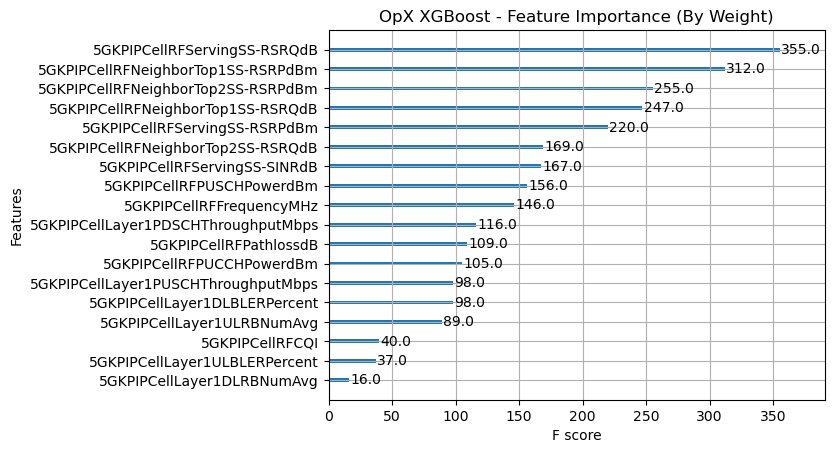

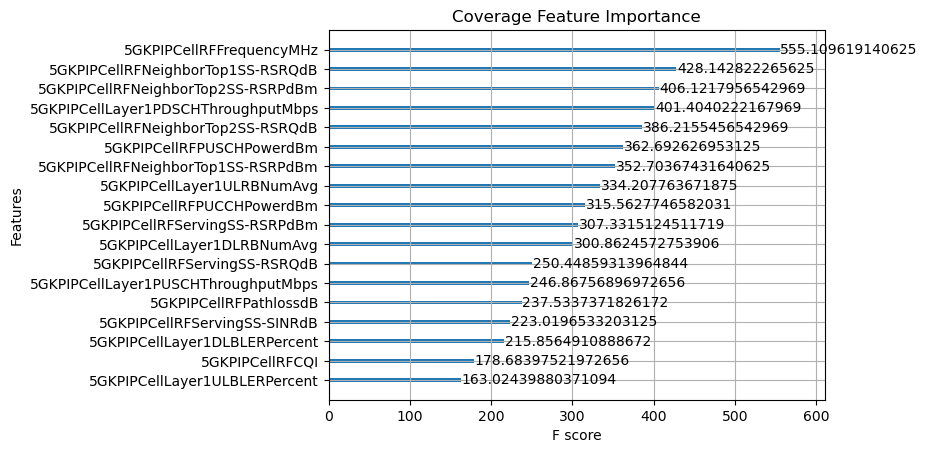

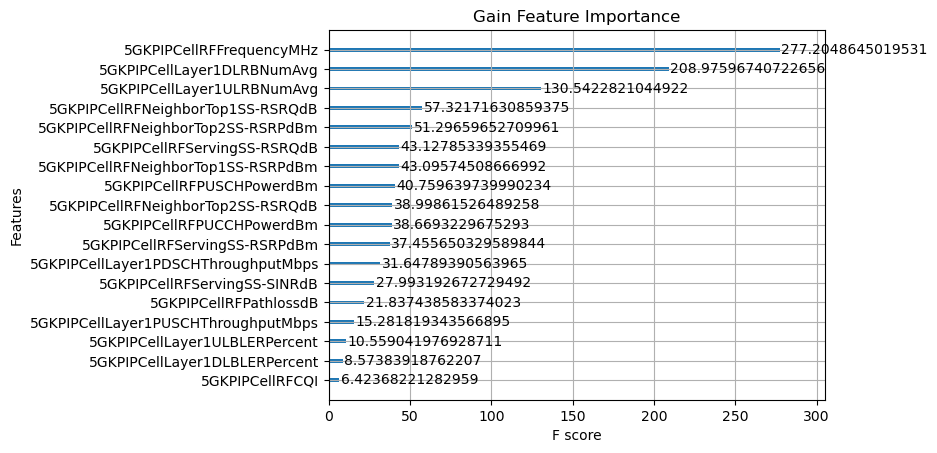

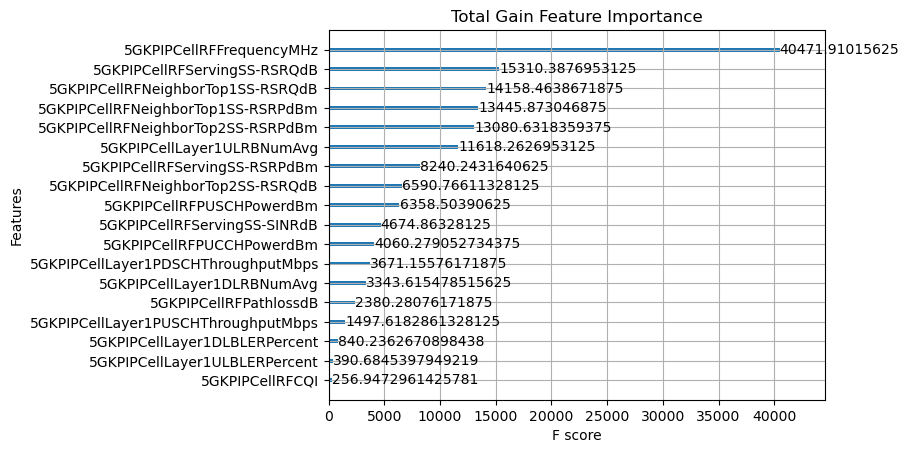

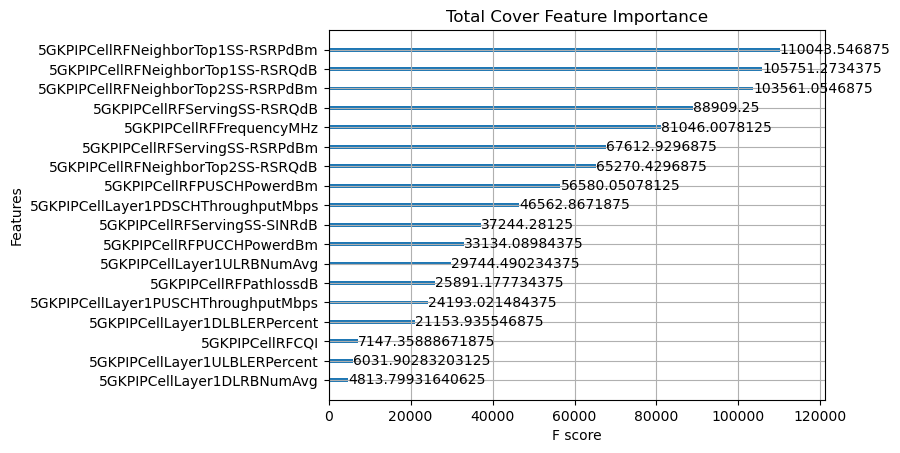

In [8]:

# Feature importance
importance_scores = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame({'feature': importance_scores.keys(), 'importance': importance_scores.values()})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop Feature Importances:")
print(importance_df)

xgb.plot_importance(final_model, importance_type="weight")
plt.title('OpX XGBoost - Feature Importance (By Weight)')
plt.show()
xgb.plot_importance(final_model, importance_type= "cover")
plt.title('Coverage Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "gain")
plt.title('Gain Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "total_gain")
plt.title('Total Gain Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "total_cover")
plt.title('Total Cover Feature Importance')
plt.show()

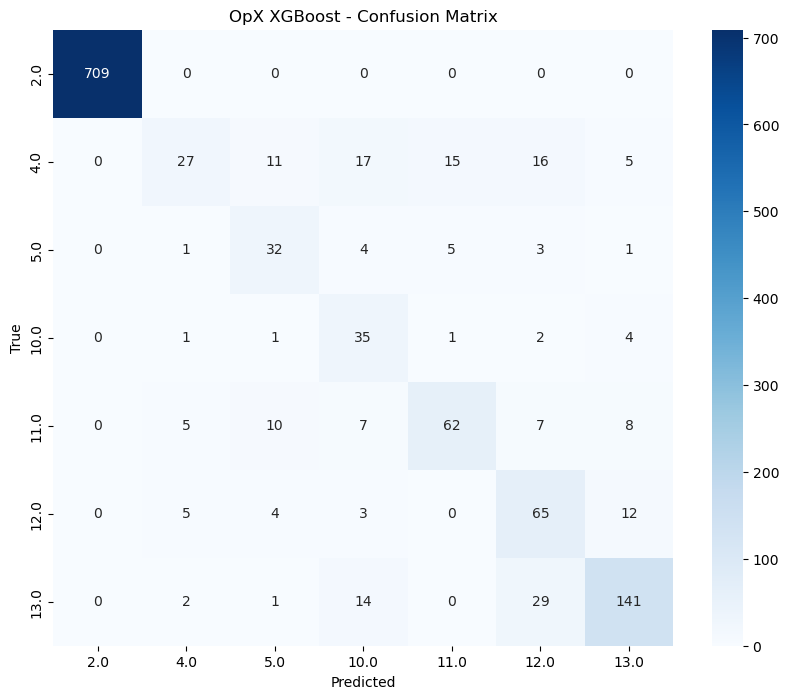

In [9]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('OpX XGBoost - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
plot_confusion_matrix(y_test, y_test_pred, classes=le.classes_)

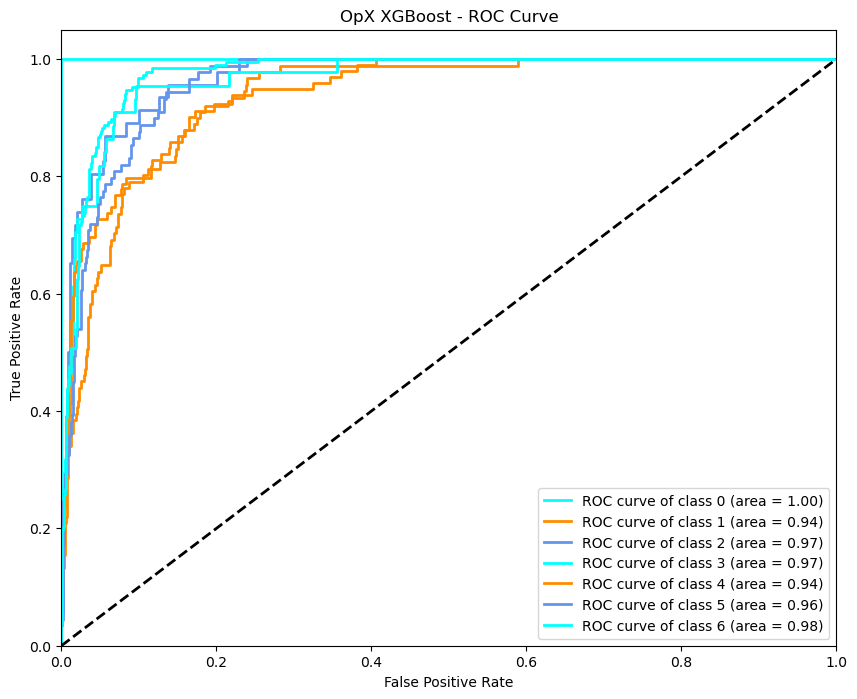

In [10]:
# ROC Curve plot
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OpX XGBoost - ROC Curve')
plt.legend(loc="lower right")
plt.show()

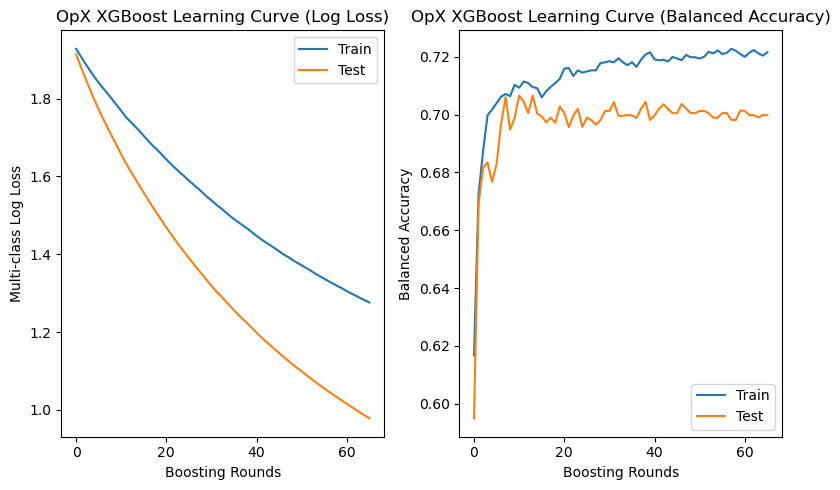

In [11]:
# Plot learning curves
def plot_learning_curves(evals_result):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(evals_result['train']['mlogloss'], label='Train')
    # plt.plot(evals_result['eval']['mlogloss'], label='Validation')
    plt.plot(evals_result['test']['mlogloss'], label='Test')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Multi-class Log Loss')
    plt.title('OpX XGBoost Learning Curve (Log Loss)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(evals_result['train']['balanced_accuracy'], label='Train')
    # plt.plot(evals_result['eval']['balanced_accuracy'], label='Validation')
    plt.plot(evals_result['test']['balanced_accuracy'], label='Test')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Balanced Accuracy')
    plt.title('OpX XGBoost Learning Curve (Balanced Accuracy)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_learning_curves(evals_result)